In [2]:
import pandas as pd
from qutip import *
import numpy as np
import torch

In [6]:
def analyze(pulse_dir, U_target):
    pulses = pd.read_csv(pulse_dir)

    _I2_CPU = torch.eye(2, dtype=torch.cfloat)
    _SIGMA_X_CPU = torch.tensor([[0.0, 1.0], [1.0, 0.0]], dtype=torch.cfloat)
    _SIGMA_Y_CPU = torch.tensor([[0.0, -1.0j], [1.0j, 0.0]], dtype=torch.cfloat)
    _SIGMA_Z_CPU = torch.tensor([[1.0, 0.0], [0.0, -1.0]], dtype=torch.cfloat)

    pauli = [_I2_CPU, _SIGMA_X_CPU, _SIGMA_Y_CPU, _SIGMA_Z_CPU]

    def generate_unitary(pulse, delta, epsilon):
        Delta = pulse[1]
        Omega = pulse[2]
        phi = pulse[3]
        tau = pulse[4] / 2

        H_base = (
            Delta* pauli[3]
            + Omega
            * (
                np.cos(phi) * pauli[1]
                + np.sin(phi) * pauli[2]
            )
        )

        H = H_base + delta * pauli[3]

        # U_k = exp(-i H_k t_k)
        return torch.linalg.matrix_exp(-1j * H * tau * (1 + epsilon))


    def spinor_to_bloch(psi: torch.Tensor) -> torch.Tensor:
        """
        Converts a spinor (2,) into a point on the Bloch sphere (3,).
        psi should be a normalized complex vector of shape (2,).
        """
        assert psi.shape == (2,), "psi must be a 2D complex vector"
        assert torch.is_complex(psi), "psi must be complex-valued"

        alpha, beta = psi[0], psi[1]
        x = 2 * torch.real(torch.conj(alpha) * beta)
        y = 2 * torch.imag(torch.conj(alpha) * beta)
        z = torch.abs(alpha)**2 - torch.abs(beta)**2

        return np.array([x, y, z])
    

    print(pulses.describe())


    bloch = Bloch()

    psi_init = torch.tensor([1, 0], dtype=torch.cfloat)
    bloch_sphere_vecs = [qutip.basis(2, 0)]
    bloch_3d_vec = [spinor_to_bloch(psi_init)]

    U_out = _I2_CPU
    evolution_time = 0

    for pulse in pulses.itertuples():
        U_step = generate_unitary(pulse, delta=0.5, epsilon=0.0)
        psi_init = U_step @ psi_init
        U_out = U_step @ U_out
        # _vec = spinor_to_bloch(psi_init)
        _vec = (
            qutip.Qobj([psi_init[0].item(), psi_init[1].item()], dims=[[2], [1]])
        ).unit()
        evolution_time += pulse[4]


        bloch_sphere_vecs.append(_vec)
        
        bloch_3d_vec.append(spinor_to_bloch(psi_init))

    bloch_3d_vec = np.array(bloch_3d_vec)
    x, y, z = bloch_3d_vec[:, 0], bloch_3d_vec[:, 1], bloch_3d_vec[:, 2]

    # Add points
    bloch.add_points([x, y, z])


    bloch.add_states(bloch_sphere_vecs[0])
    bloch.add_states(bloch_sphere_vecs[-1])


    # Add dashed lines manually
    for i in range(len(bloch_sphere_vecs) - 1):
        pt1 = bloch_sphere_vecs[i]
        pt2 = bloch_sphere_vecs[i+1]


        bloch.add_arc(
            pt1, pt2,
        )

    bloch.show()

    print(U_out)

    print(f"Total Evolution time: {evolution_time / np.pi} pi")

X(pi)
tensor([[0.+0.0000j, 0.-1.0000j],
        [0.-1.0000j, 0.+0.0000j]])
                0           1           2           3
count  200.000000  200.000000  200.000000  200.000000
mean    -0.320618    0.952548    0.105212    0.115317
std      1.810914    0.127144    1.966018    0.079506
min     -4.169206    0.032593   -3.130869    0.001023
25%     -1.694571    0.970054   -1.974782    0.061010
50%     -0.357850    0.995595    0.583206    0.094382
75%      0.935937    0.998948    1.829864    0.157671
max      4.262793    0.999792    3.126888    0.392459


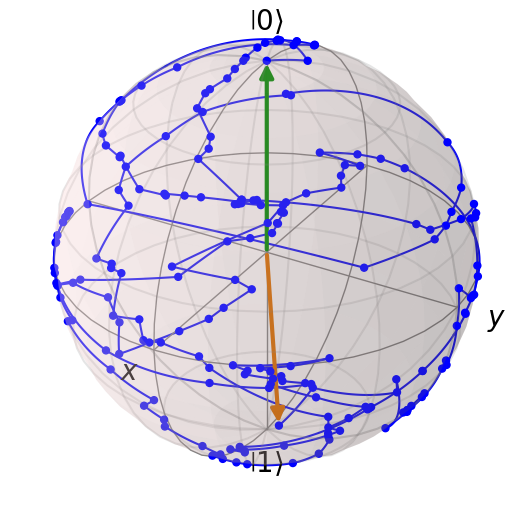

tensor([[ 0.0200-0.0264j,  0.0495+0.9982j],
        [-0.0495+0.9982j,  0.0200+0.0264j]])
Total Evolution time: 7.341323564926912 pi
X(pi-2)
tensor([[0.7071+0.0000j, 0.0000-0.7071j],
        [0.0000-0.7071j, 0.7071+0.0000j]])
                0           1           2           3
count  200.000000  200.000000  200.000000  200.000000
mean    -0.259286    0.952924    0.090534    0.118163
std      1.858494    0.126781    1.952280    0.086158
min     -4.202691    0.037928   -3.131083    0.001159
25%     -1.661111    0.974150   -1.849975    0.061155
50%     -0.340705    0.995358    0.531647    0.101966
75%      1.022493    0.998985    1.835577    0.160460
max      4.407945    0.999839    3.128062    0.458364


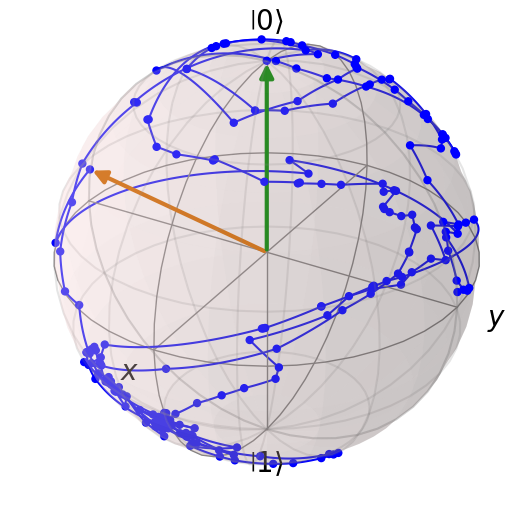

tensor([[-0.7682+0.0115j, -0.0064+0.6401j],
        [ 0.0064+0.6401j, -0.7682-0.0115j]])
Total Evolution time: 7.522503676247069 pi
Hadamard
tensor([[2.3842e-07-0.7071j, 0.0000e+00-0.7071j],
        [0.0000e+00-0.7071j, 2.3842e-07+0.7071j]])
                0           1           2           3
count  200.000000  200.000000  200.000000  200.000000
mean    -0.368546    0.957358    0.146489    0.111568
std      1.785182    0.117375    1.968308    0.075536
min     -4.100496    0.034296   -3.131053    0.000884
25%     -1.682631    0.974893   -1.853388    0.061192
50%     -0.420401    0.995349    0.757234    0.093621
75%      0.807825    0.998890    1.855848    0.150128
max      4.200988    0.999786    3.126781    0.386697


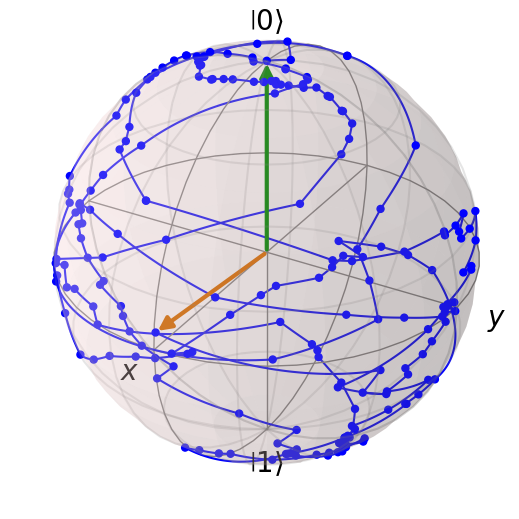

tensor([[-0.0434+0.7374j,  0.0453+0.6725j],
        [-0.0453+0.6725j, -0.0434-0.7374j]])
Total Evolution time: 7.102614683031256 pi
Z(pi-4)
tensor([[0.9239-0.3827j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.9239+0.3827j]])
                0           1           2           3
count  200.000000  200.000000  200.000000  200.000000
mean    -0.240734    0.963800    0.225478    0.114703
std      1.860195    0.107498    1.967145    0.083548
min     -3.919488    0.029172   -3.126955    0.000634
25%     -1.524561    0.979120   -1.702062    0.062551
50%     -0.289841    0.994750    0.951737    0.095981
75%      1.178663    0.998639    1.826687    0.152152
max      4.574420    0.999799    3.125659    0.427158


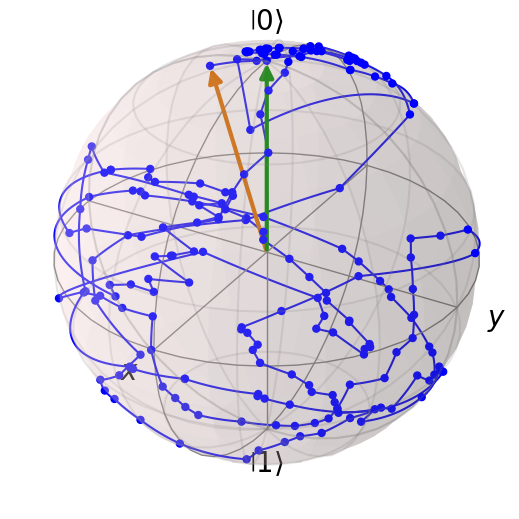

tensor([[ 0.9032-0.4089j, -0.0041-0.1299j],
        [ 0.0041-0.1299j,  0.9032+0.4089j]])
Total Evolution time: 7.302240977749446 pi


In [7]:
from train.single_qubit.single_qubit_script import *

U_targets = build_dataset()

U_target_names = [
    "X(pi)",
    "X(pi-2)",
    "Hadamard",
    "Z(pi-4)"
]


for U_target, name in zip(U_targets, U_target_names):
    pulse_dir = f"weights/single_qubit_control/{name}_pulse.csv"
    print(name)
    print(U_target)
    analyze(pulse_dir, U_target)

In [ ]:
# X(pi)

U_target = np.array([[0, 1], [1, 0]])

pulse_dir = "pulses/X(pi)_pulse.csv"



pulses

,0,1,2,3
0,2.971277,0.999353,-0.370054,0.115060
1,2.760738,0.999071,0.615521,0.190045
2,2.790707,0.993635,1.088363,0.105200
3,2.775569,0.886837,-2.228889,0.042964
4,3.292843,0.954029,0.879183,0.141995
...,...,...,...,...
95,3.199315,0.997407,-1.338825,0.122817
96,3.422556,0.997575,-0.607630,0.164856
97,2.871815,0.998916,0.028936,0.086291
98,2.618267,0.997095,0.468693,0.040301


,0,1,2,3
count,100.000000,100.000000,100.000000,100.000000
mean,2.976850,0.996863,0.038945,0.105876
std,0.641252,0.012522,1.808758,0.042656
min,1.371399,0.886837,-3.135897,0.004417
25%,2.617532,0.998648,-1.468213,0.080550
50%,2.974550,0.999507,0.121511,0.104624
75%,3.387212,0.999864,1.571832,0.133797
max,4.596583,0.999996,3.141275,0.216534


In [74]:
pulse

Pandas(Index=99, _1=0.64630604, _2=0.7743179, _3=-3.0904193, _4=0.06982807)

In [75]:
qutip.basis(2, 0), qutip.basis(2, 1)

(Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[1.]
  [0.]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.]
  [1.]])

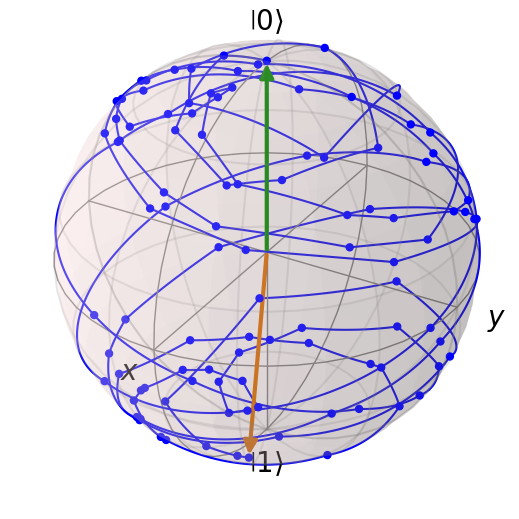

tensor([[ 0.0651+0.1638j, -0.1008+0.9791j],
        [ 0.1008+0.9791j,  0.0651-0.1638j]])
Total Evolution time: 3.3701358512861006 pi
